This notebook provides some analysis snippets for extragalactic foregounds computation with `pysm3`



## Preamble



Matplotlib magic



In [1]:
%matplotlib inline

In [2]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pspy
import pysm
import pysm.units as u
print(" healpy :", hp.__version__)
print("  numpy :", np.__version__)
print("   pysm :", pysm.__version__)
print("   pspy :", pspy.__version__)

 healpy : 1.13.0
  numpy : 1.18.1
   pysm : 3.1.dev265
   pspy : 1.2.1


## Getting started:PROPERTIES:



This is a basic copy-paste of `pysm3` [tutorials](https://pysm3.readthedocs.io/en/latest/basic_use.html). Here we consider dust (`d1` model) and synchrotron (`s1`)
emission.



In [1]:
sky = pysm.Sky(nside=128, preset_strings=["d1", "s1"])
map_100GHz = sky.get_emission(100 * u.GHz)
print(map_100GHz[0, :3])

We can convert unit to CMB µK



In [1]:
map_100GHz = map_100GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(100*u.GHz))
print(map_100GHz[0, :3])

We can also show the I, Q, U maps for the two different models



In [1]:
presets = ["d1", "s1"]
sky = pysm.Sky(nside=128, preset_strings=presets)

frequency = 100 * u.GHz
def µK_to_µCMB(sky_map):
  return sky_map.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(frequency))

sky_maps = {"Model '{}'".format(model):
            µK_to_µCMB(sky.components[i].get_emission(frequency))
            for i, model in enumerate(presets)}
sky_maps["+".join(presets)] = µK_to_µCMB(sky.get_emission(frequency))

plt.figure(figsize=(12, 6))
for i, (model, sky_map) in enumerate(sky_maps.items()):
    for j, spec in enumerate(["I", "Q", "U"]):
      vmin, vmax = 0, 100 if spec == "I" else 10
      hp.mollview(sky_map[j],
                  min=vmin, max=vmax,
                  cbar=False,
                  title="{} - {}".format(spec, model),
                  sub=(3, 3, 3*i+j+1))

We can finally plot the corresponding power spectra



In [1]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)
axes = axes.flatten()

cls = {k: hp.anafast(v) for k, v in sky_maps.items()}
for k, v in cls.items():
    ell = np.arange(v.shape[1])
    for i, cl in enumerate(["TT", "EE", "BB", "TE", "EB", "TB"]):
        plot = axes[i].loglog if i == 0 else axes[i].semilogx
        plot(ell, v[i])
        axes[i].legend([], title=cl)
for ax in axes[3:]:
  ax.set_xlabel("$\ell$")
fig.legend(cls.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)
plt.tight_layout()

## Comparing =pspy= to =healpy.anafast=:PROPERTIES:



Here we check for CMB data, how calculation of power spectra with `pspy` differs from the one of
`healpy.anafast` which does not take care of mask. We also look how `pspy` behaves wrt to the number of
iterations.



### Definining mask



Masks are defined in galactic coordinates for later use with `pysm`. Everything is done with
`nside=1024`.



In [1]:
nside = 1024
galactic_mask = np.load("./masks/mask_galactic_1024.npz")["mask"]
survey_mask = np.load("./masks/mask_survey_1024.npz")["mask"]
mask = galactic_mask * survey_mask
plt.figure(figsize=(12, 4))
hp.mollview(galactic_mask, title="Galactic", sub=(1, 2, 1))
hp.mollview(survey_mask, title="Survey", sub=(1, 2, 2))

Given the two masks, we create a `so_map` object to store the survey



In [1]:
from pspy import so_map
survey = so_map.healpix_template(ncomp=1, nside=nside)
survey.data = mask

and we apodize it with circular beam of 5 degree



In [1]:
from pspy import so_window
survey = so_window.create_apodization(survey, apo_type="C1", apo_radius_degree=5)
hp.mollview(survey.data, title=None)

### Create binning file and MCM computation



We first create a binning file



In [1]:
import os
output_dir = "/tmp/pysm"
os.makedirs(output_dir, exist_ok=True)
binning_file = os.path.join(output_dir, "binning.dat")
from pspy import pspy_utils
pspy_utils.create_binning_file(bin_size=40, n_bins=100, file_name=binning_file)

Comptutation of matrix coupling mode and Bbl are done for different number of iterations



In [1]:
window = (survey, survey)
lmax = 3 * nside - 1
from pspy import so_mcm
mcms = [so_mcm.mcm_and_bbl_spin0and2(window, binning_file, lmax=lmax, type="Dl", niter=n) for n in range(4)]

### CMB spectra



Using [CAMB](https://camb.readthedocs.io/en/latest/) and a set of cosmological parameters, we can produce $C_\ell$ for the different spectra



In [15]:
import camb
cosmo_params = {
    "H0": 67.5,
    "As": 1e-10*np.exp(3.044),
    "ombh2": 0.02237,
    "omch2": 0.1200,
    "ns": 0.9649,
    "Alens": 1.0,
    "tau": 0.0544
}
ell_camb_min, ell_camb_max = 2, 10**4
pars = camb.set_params(**cosmo_params)
pars.set_for_lmax(ell_camb_max, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")

ell_camb = np.arange(ell_camb_min, ell_camb_max)
cl_file = os.path.join(output_dir, "cl_camb.dat")
np.savetxt(cl_file,
           np.hstack([ell_camb[:, np.newaxis], powers["total"][ell_camb_min:ell_camb_max]]))

Fro sanity checks, we can show the power spectra



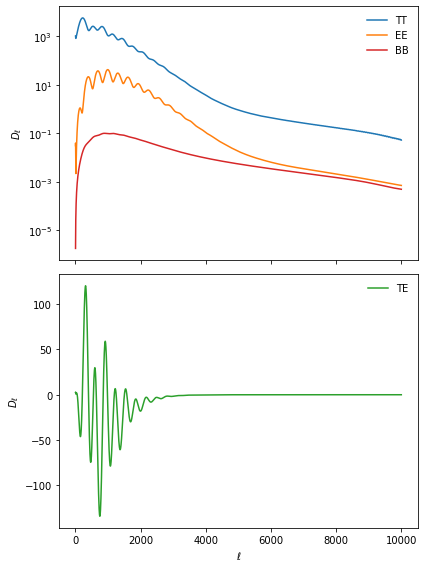

In [16]:
dl_dict = {k: powers["total"][ell_camb_min:ell_camb_max, v]
           for k, v in {"tt": 0, "ee": 1, "te": 3, "bb": 2}.items()}
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
axes[0].set_yscale("log")
for i, spec in enumerate(dl_dict.keys()):
    ax = axes[1] if spec == "te" else axes[0]
    ax.plot(ell_camb, dl_dict[spec], "-C{}".format(i), label=spec.upper())

for ax in axes:
    ax.set_ylabel(r"$D_\ell$")
    ax.legend()
    axes[1].set_xlabel(r"$\ell$")
    plt.tight_layout()

Given the $C_\ell$, we can now generate a CMB map



In [17]:
tmpl = so_map.healpix_template(ncomp=3, nside=nside)
cmb = tmpl.synfast(cl_file)

and show the intensity map with the mask



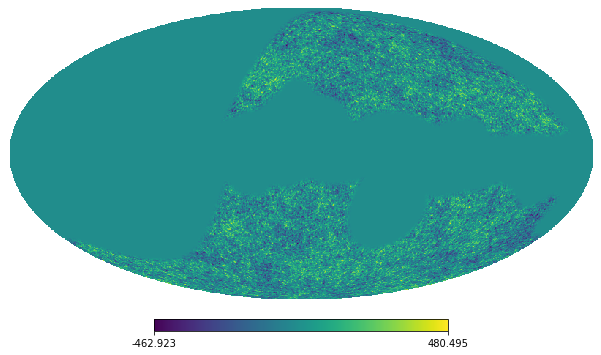

In [18]:
hp.mollview(cmb.data[0]*survey.data, title=None)

Now, we can compute alm



In [1]:
spectra = ["TT", "TE", "TB", "ET", "BT", "EE", "EB", "BE", "BB"]
Db_dict = {}
for n in range(4):
    from pspy import sph_tools
    alm = sph_tools.get_alms(cmb, window, niter=n, lmax=lmax)

    from pspy import so_spectra
    Db_dict[n] = so_spectra.bin_spectra(*so_spectra.get_spectra(alm, spectra=spectra),
                                        binning_file,
                                        lmax,
                                        type="Dl",
                                        mbb_inv=mcms[n][0],
                                        spectra=spectra)

and plot the power spectra for the different number of iterations.



In [1]:
from pspy import pspy_utils
ell_theory, ps_theory = pspy_utils.ps_lensed_theory_to_dict(cl_file, "Dl", lmax=lmax)

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
ax = axes.flatten()
for i, spec in enumerate(["TT", "EE", "BB", "TE", "EB", "TB"]):
    for n, v in Db_dict.items():
        l, ps = v[0], v[1][spec]
        ps_theory_b = so_mcm.apply_Bbl(mcms[n][1], ps_theory, spectra=spectra)
        ax[i].plot(l, ps, "-C{}".format(n), label="n = {}".format(n))
        # ax[i].plot(l, ps_theory_b[spec], "-C{}".format(n), label="n = {}".format(n))
    # ax[i].plot(lb, ps_theory_b[spec], "o", color="tab:red", label="binned theory")
    ax[i].plot(ell_theory, ps_theory[spec], color="gray", label="theory")
    ax[i].set_ylabel(r'$D^{%s}_{\ell}$'%spec, fontsize=20)
    if i==0:
        fig.legend(loc="upper left", bbox_to_anchor=(1,1))

for ax in axes[-1]:
    ax.set_xlabel(r'$\ell$',fontsize=20)
plt.tight_layout()

For a number of iteration of 3, we can now compare `pspy` computation of power spectra  with
`healpy.anafast`. As a reminder, `healpy.anafast` does not take into account the mask and is only
reliable for full sky. We compute the $C_\ell$ *via* `anafast` with and without mask



In [1]:
cls_ana = hp.anafast(cmb.data)
cls_ana_masked = hp.anafast(survey.data * cmb.data)

and let's plot them together with the `pspy` computation



In [1]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
ax = axes.flatten()
for i, spec in enumerate(["TT", "EE", "BB", "TE", "EB", "TB"]):
    l = np.arange(cls_ana[i].shape[0])
    norm = l * (l + 1) / (2 * np.pi)
    ax[i].plot(l, cls_ana[i] * norm, "0.5", label="anafast")
    ax[i].plot(l, cls_ana_masked[i] * norm, "0.75", label="anafast with mask")
    ax[i].set_ylabel(r'$D^{%s}_{\ell}$'%spec, fontsize=20)
    n = 3
    l, ps = Db_dict[n][0], Db_dict[n][1][spec]
    ax[i].plot(l, ps, "tab:red", label="pspy - n = {}".format(n))
    if i == 0:
        fig.legend(loc="upper left", bbox_to_anchor=(1,1))

for ax in axes[-1]:
    ax.set_xlabel(r'$\ell$',fontsize=20)
plt.tight_layout()

## Comparing galactic emission models



### Defining mask



Since `pysm` generates maps in galactic coordinates and we do not want to rotate each of the, we grab
the galatic and the SO survey masks both in galactic coordinates with `nside=1024`



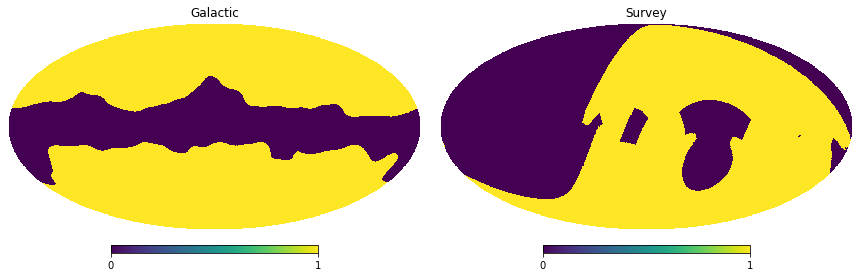

In [3]:
nside = 1024
galactic_mask = np.load("./masks/mask_galactic_1024.npz")["mask"]
survey_mask = np.load("./masks/mask_survey_1024.npz")["mask"]
mask = galactic_mask * survey_mask
plt.figure(figsize=(12, 4))
hp.mollview(galactic_mask, title="Galactic", sub=(1, 2, 1))
hp.mollview(survey_mask, title="Survey", sub=(1, 2, 2))

If we want bigger `nside`, we can upgrade the map



In [4]:
mask = hp.ud_grade(mask, nside_out=nside)
assert np.all((mask == 0) | (mask == 1)), "Some pixels have value != 0 or 1"

Given the two masks, we create a `so_map` object to store the survey



In [5]:
from pspy import so_map
survey = so_map.healpix_template(ncomp=1, nside=nside)
survey.data = mask

and we apodize it with circular beam of 5 degree



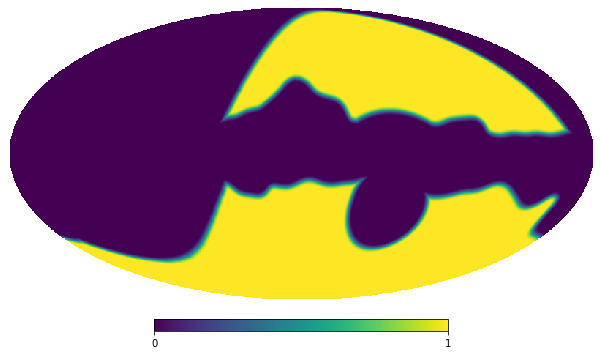

In [6]:
from pspy import so_window
survey = so_window.create_apodization(survey, apo_type="C1", apo_radius_degree=5)
hp.mollview(survey.data, title=None)

Let's try to mask the dust emission for instance and see the remnant emission at 100 GHz



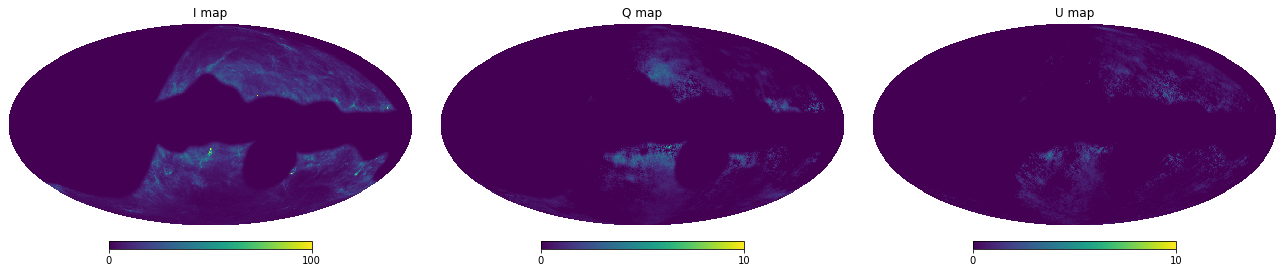

In [7]:
sky = pysm.Sky(nside=nside, preset_strings=["d1"], output_unit=u.uK_CMB)
map_100GHz = sky.get_emission(100 * u.GHz)
plt.figure(figsize=(18, 4))
hp.mollview(survey.data * map_100GHz[0], min=0, max=100, title="I map", sub=(1, 3, 1))
hp.mollview(survey.data * map_100GHz[1], min=0, max=10, title="Q map", sub=(1, 3, 2))
hp.mollview(survey.data * map_100GHz[2], min=0, max=10, title="U map", sub=(1, 3, 3))

### Create binning file and MCM computation



We first create a binning file



In [8]:
import os
output_dir = "/tmp/pysm"
os.makedirs(output_dir, exist_ok=True)
binning_file = os.path.join(output_dir, "binning.dat")
from pspy import pspy_utils
pspy_utils.create_binning_file(bin_size=40, n_bins=1000, file_name=binning_file)

Comptutation of matrix coupling mode and Bbl are done for different number of iterations



In [9]:
window = (survey, survey)
lmax = 3 * nside - 1
niter = 3
from pspy import so_mcm
mbb_inv, bbl = so_mcm.mcm_and_bbl_spin0and2(window,
                                            binning_file,
                                            lmax=lmax,
                                            type="Dl",
                                            niter=niter)

### Defining models & frequencies



In [10]:
dust = ["d0", "d1", "d2", "d4", "d6"]  # "d5"
synchrotron = ["s1", "s2", "s3"]
ame = ["a1", "a2"]
free_free = ["f1"]

presets = dust + synchrotron + ame + free_free
frequencies = [93, 145, 225]

store_map = False
store_alms = False
store_spectra = True

### Compute emission maps, alms and spectra



In [11]:
models = {k: {} for k in presets}

from itertools import product
for preset, freq in product(presets, frequencies):
  print("Computing {} model @ {} GHz".format(preset, freq))

  # Get emission map
  sky = pysm.Sky(nside=nside, preset_strings=[preset], output_unit=u.uK_CMB)
  emission = sky.get_emission(freq * u.GHz)

  # Compute alm
  from pspy import sph_tools
  tmpl = so_map.healpix_template(ncomp=3, nside=nside)
  tmpl.data = emission.value
  alms = sph_tools.get_alms(tmpl, window, niter=niter, lmax=lmax)

  # Compute spectra
  from pspy import so_spectra
  spectra = ["TT", "TE", "TB", "ET", "BT", "EE", "EB", "BE", "BB"]
  db = so_spectra.bin_spectra(*so_spectra.get_spectra(alms, spectra=spectra),
                              binning_file,
                              lmax=lmax,
                              type="Dl",
                              mbb_inv=mbb_inv,
                              spectra=spectra)
  models[preset][freq] = {"spectra": db}

  if store_map:
    models[preset][freq].update({"map": emission})
  if store_alms:
    models[preset][freq].update({"alms": alms})

Computing d0 model @ 93 GHz
Computing d0 model @ 145 GHz
Computing d0 model @ 225 GHz
Computing d1 model @ 93 GHz
Computing d1 model @ 145 GHz
Computing d1 model @ 225 GHz
Computing d2 model @ 93 GHz
Computing d2 model @ 145 GHz
Computing d2 model @ 225 GHz
Computing d4 model @ 93 GHz
Computing d4 model @ 145 GHz
Computing d4 model @ 225 GHz
Computing d6 model @ 93 GHz
Computing d6 model @ 145 GHz
Computing d6 model @ 225 GHz
Computing s1 model @ 93 GHz
Computing s1 model @ 145 GHz
Computing s1 model @ 225 GHz
Computing s2 model @ 93 GHz
Computing s2 model @ 145 GHz
Computing s2 model @ 225 GHz
Computing s3 model @ 93 GHz
Computing s3 model @ 145 GHz
Computing s3 model @ 225 GHz
Computing a1 model @ 93 GHz
Computing a1 model @ 145 GHz
Computing a1 model @ 225 GHz
Computing a2 model @ 93 GHz


/home/garrido/Workdir/CMB/development/pysm/software/pysm/models/template.py:194: UserWarning: No physical unit associated with file /home/garrido/.astropy/cache/download/py3/6d109847b43f9d9e40f0301031194286
  warnings.warn("No physical unit associated with file " + str(path))
/home/garrido/Workdir/CMB/development/pysm/software/pysm/models/template.py:194: UserWarning: No physical unit associated with file /home/garrido/.astropy/cache/download/py3/24e4f022b8fd1e7ba0278d56e4bfb719
  warnings.warn("No physical unit associated with file " + str(path))


Computing a2 model @ 145 GHz


/home/garrido/Workdir/CMB/development/pysm/software/pysm/models/template.py:194: UserWarning: No physical unit associated with file /home/garrido/.astropy/cache/download/py3/6d109847b43f9d9e40f0301031194286
  warnings.warn("No physical unit associated with file " + str(path))
/home/garrido/Workdir/CMB/development/pysm/software/pysm/models/template.py:194: UserWarning: No physical unit associated with file /home/garrido/.astropy/cache/download/py3/24e4f022b8fd1e7ba0278d56e4bfb719
  warnings.warn("No physical unit associated with file " + str(path))


Computing a2 model @ 225 GHz
Computing f1 model @ 93 GHz
Computing f1 model @ 145 GHz
Computing f1 model @ 225 GHz


In [12]:
import pickle
pickle.dump(models, open("./models_1024.pkl", "wb"))

#### Plotting spectra



In [13]:
def plot_spectra(models=models, spec="TT", lmax=lmax):
    nfreq = len(frequencies)
    fig, axes = plt.subplots(4, nfreq, sharex=True, sharey="row", figsize=(15, 12))
    if spec in ["TT", "EE", "BB"]:
        [ax.set_yscale("log") for ax in axes.flatten()]

    def _plot_spectra(submodels, row_number):
        for i, (model, freq) in enumerate(product(submodels, frequencies)):
            lb, db = models[model][freq].get("spectra")
            axes[row_number, i%3].plot(lb, db[spec], label=model)

    # Show CMB
    for ax in axes.flatten():
        ax.plot(ell_camb, dl_dict[spec.lower()], "gray", label="CMB")
        ax.set_xlim(0, lmax)

    names = {"dust": dust, "synchrotron": synchrotron, "AME": ame, "free-free": free_free}
    for i, submodel in enumerate(names.values()):
        _plot_spectra(submodel, i)

    for ax, name in zip(axes[:, -1], names.keys()):
        leg = ax.legend(title="{} - {}".format(spec, name), bbox_to_anchor=(1, 1), loc="upper left")
        leg._legend_box.align = "left"

    for ax in axes[:, 0]:
        ax.set_ylabel(r"$D_\ell$")
    for ax in axes[-1]:
        ax.set_xlabel(r"$\ell$")

    for ax, freq in zip(axes[0], frequencies):
        ax.set_title("{} GHz".format(freq))
    plt.tight_layout()

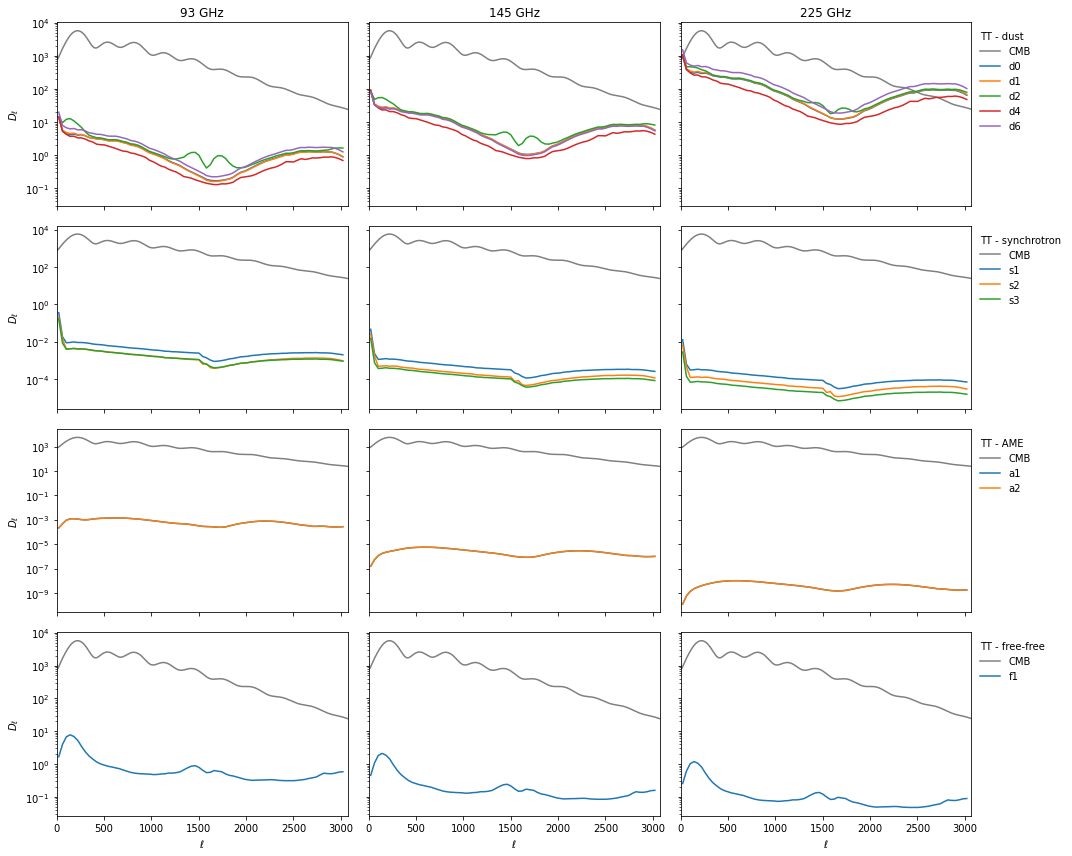

In [19]:
plot_spectra()

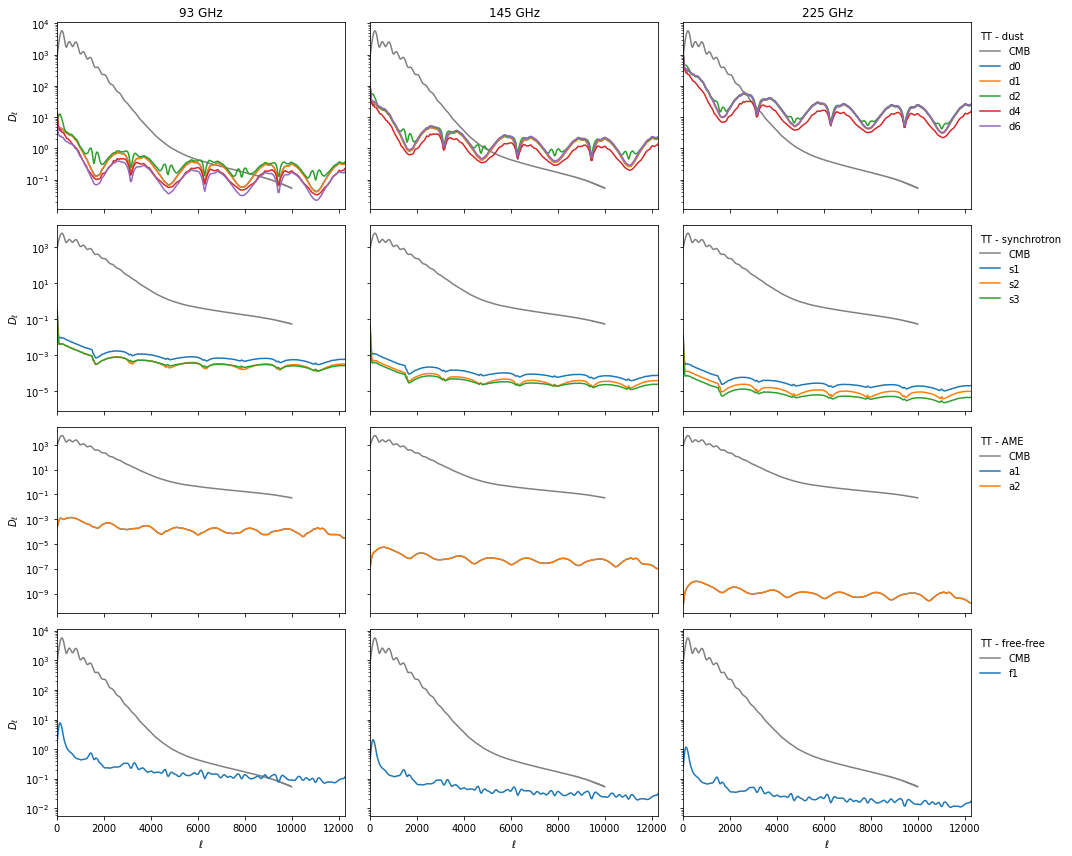

In [20]:
nside = 4096
plot_spectra(spec="TT",
             models=pickle.load(open("./models_{}.pkl".format(nside), "rb")),
             lmax=3*nside-1)

#### Plotting maps



In [1]:
frequency = 93
I, Q, U = 0, 1, 2
select = I

ncols = len(frequencies)
nrows = len(presets)

fig = plt.figure(figsize=(18, 5*nrows), num=0)
# fig.suptitle("coucou")
i = 1
for model, preset in models.items():
    for freq in frequencies:
        hp.mollview(preset[freq].get("map")[select], min=0, max=100, sub=(nrows, ncols, i), title=None, cbar=False)
        i += 1